# **Imports and common function**

In [35]:
import re
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import models, layers
from keras.preprocessing import sequence, text
from keras.models import model_from_json
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import pickle
import nltk
import os
import pandas as pd
import seaborn as sns
from google.colab import drive


drive.mount('/content/gdrive')
nltk.download('punkt')
nltk.download('wordnet')


def LemmaTokenizer(articles):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(t) for t in word_tokenize(articles)]

def filter_function(x):
    return re.sub(r'(_)|(\d[0-9.]*)', ' ', x.lower())

def print_history(history):
    epochs = range(len(history.history['acc']))
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
def anaylze_model(model, test_data):
  y_pred = model.predict_classes(test_data)
  y_true = data.target[split_index:]
  classes = data.target_names
  
  print('F1-Score (weighted): ', f1_score(y_true, y_pred, labels=np.unique(y_pred), average='weighted'))
  
  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).eval(session=tf.compat.v1.Session())
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                       index = classes, 
                       columns = classes)
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                       index = classes, 
                       columns = classes)
  figure = plt.figure(figsize=(11, 11))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Data preparation**

**Prepare the 20 news groups dataset and split it into training set and validation set.**
**These data are used in following two models**

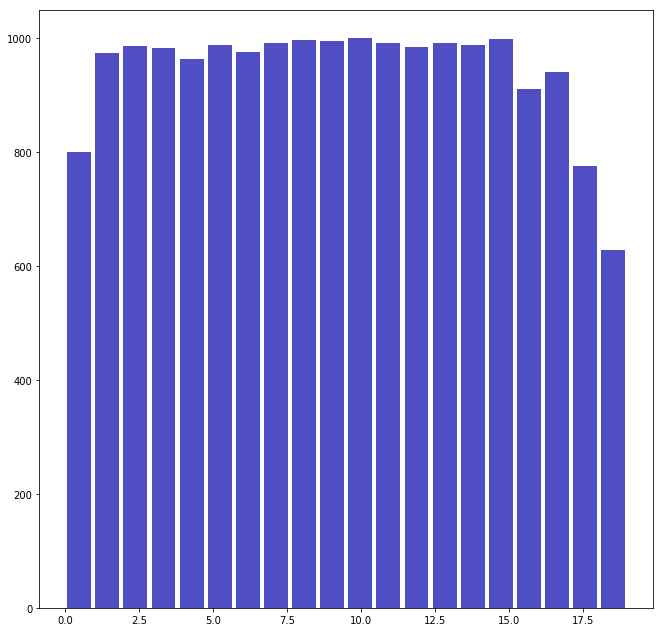

In [17]:
data = fetch_20newsgroups(subset='all', shuffle=False)    #  remove=('headers', 'footers', 'quotes')
split_index = int(len(data.data)*0.83)
num_of_categories = 20
train_labels_oneHot = to_categorical(data.target[:split_index])
test_labels_oneHot = to_categorical(data.target[split_index:])
train = data.data[:split_index]
test = data.data[split_index:]


figure = plt.figure(figsize=(11, 11))
plt.hist(data.target, bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

In [5]:
# read models from files

def load_model(model_file, weights_file, text_transformer_file):
    path = '/content/gdrive/My Drive/Colab Notebooks/'
    model_file = path + model_file
    weights_file = path + weights_file
    text_transformer_file = path + text_transformer_file
    with open(model_file, 'r') as json_file:
        _model = model_from_json(json_file.read())
        _model.load_weights(weights_file)
        print("Loaded model from disk")
        with open(text_transformer_file, 'rb') as f:
            _text_transformer = pickle.load(f, encoding='latin1')
            return _model, _text_transformer
    print("Couldn't load model")


tfidf_model, vectorizer = load_model('model_tfidf.json', 'model_tfidf.h5', 'vectorizer_tfidf.pkl')
rnn_model, tokenizer = load_model('model_rnn.json', 'model_rnn.h5', 'tokenizer_rnn.pkl')
print("Model is loaded and ready to use")






Loaded model from disk

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
Model is loaded and ready to use


# **RNN / CNN method**
Best score: 85% of test accuracy (without pre-trained embedding layer it's only 50%)

**Fix parameters for the model**

In [0]:
top_words = 140000
EMBEDDING_DIM = 50    # == 50, because of fixed pre-trained vector size
tokenizer = text.Tokenizer(num_words=top_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                           lower=True, split=' ', char_level=False, oov_token=None)
tokenizer.fit_on_texts(train)
with open('/content/gdrive/My Drive/Colab Notebooks/tokenizer_rnn.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [6]:
max_review_length = 1250
X_train = tokenizer.texts_to_sequences(train)
X_test = tokenizer.texts_to_sequences(test)
train_rnn = sequence.pad_sequences(X_train, maxlen=max_review_length)
test_rnn = sequence.pad_sequences(X_test, maxlen=max_review_length)

word_index = tokenizer.word_index
print("Words indexed: ", len(word_index))


Words indexed:  165648


**Load the pretrained embedding layer**

In [13]:
embeddings_index = {}
f = open('/content/gdrive/My Drive/Colab Notebooks/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

PretrainedEmbeddingLayer = layers.Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=max_review_length,
                            trainable=False)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 400000 word vectors.



**Train the classifier**






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 15642 samples, validate on 3204 samples
Epoch 1/30
15642/15642 [==============================] - 57s 4ms/step - loss: 2.7762 - acc: 0.1092 - val_loss: 2.3704 - val_acc: 0.1710
Epoch 2/30
15642/15642 [==============================] - 52s 3ms/step - loss: 2.2458 - acc: 0.2167 - val_loss: 2.1016 - val_acc: 0.2544
Epoch 3/30
15642/15642 [==============================] - 51s 3ms/step - loss: 1.9521 - acc: 0.3062 - val_loss: 1.7537 - val_acc: 0.3536
Epoch 4/30
15642/15642 [==============================] - 51s 3ms/step - loss: 1.6894 - acc: 0.3898 - val_loss: 1.5758 - val_acc: 0.4391
Epoch 5/30
15642/15642 [==============================] - 52s 3ms/step - loss: 1.5073 - acc: 0.4510 - val_loss: 1.4102 - val_acc: 0.4819
Epoch 6/30
15642/15642 [===========================

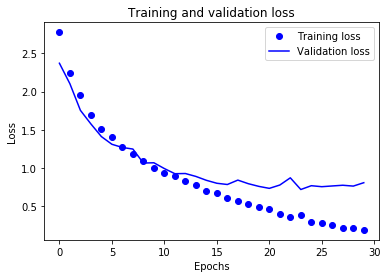

In [14]:
rnn_model = models.Sequential()
rnn_model.add(PretrainedEmbeddingLayer)
rnn_model.add(layers.Conv1D(filters=200, kernel_size=5, padding='same', activation='relu'))
rnn_model.add(layers.MaxPooling1D(pool_size=2))
rnn_model.add(layers.Conv1D(filters=200, kernel_size=5, padding='same', activation='relu'))
rnn_model.add(layers.MaxPooling1D(pool_size=2))
rnn_model.add(layers.Dropout(0.2))
rnn_model.add(layers.LSTM(300, recurrent_dropout=0.2))
rnn_model.add(layers.Dense(350, activation='relu'))
rnn_model.add(layers.Dropout(0.2))
rnn_model.add(layers.Dense(350, activation='relu'))
rnn_model.add(layers.Dropout(0.2))
rnn_model.add(layers.Dense(num_of_categories, activation='softmax'))
rnn_model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = rnn_model.fit(train_rnn, train_labels_oneHot, epochs=30, batch_size=500,
                    validation_data=(test_rnn, test_labels_oneHot))
print_history(history)
# serialize model to JSON
model_json = rnn_model.to_json()
with open("model_rnn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
rnn_model.save_weights("model_rnn.h5")
print("Saved model to disk")

# **TF-IDF method with stop words removal**


**Tokenize text, remove stop words and use word indexing**

In [0]:
vectorizer = TfidfVectorizer(stop_words='english',
                             tokenizer = LemmaTokenizer,
                             use_idf = True,
                             lowercase = True,
                             preprocessor = filter_function)
vectorizer.fit(train)
with open('/content/gdrive/My Drive/Colab Notebooks/vectorizer_tfidf.pkl', 'wb') as f:
     pickle.dump(vectorizer, f)

In [7]:
train_tfidf = vectorizer.transform(train)
test_tfidf = vectorizer.transform(test)
print("Shape: ", train_tfidf.shape)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Shape:  (15642, 158881)


Train on 15642 samples, validate on 3204 samples
Epoch 1/8
15642/15642 [==============================] - 21s 1ms/step - loss: 2.2852 - acc: 0.7497 - val_loss: 1.5550 - val_acc: 0.8480
Epoch 2/8
15642/15642 [==============================] - 20s 1ms/step - loss: 0.9495 - acc: 0.9269 - val_loss: 0.7205 - val_acc: 0.9026
Epoch 3/8
15642/15642 [==============================] - 20s 1ms/step - loss: 0.3941 - acc: 0.9587 - val_loss: 0.4428 - val_acc: 0.9167
Epoch 4/8
15642/15642 [==============================] - 20s 1ms/step - loss: 0.2000 - acc: 0.9730 - val_loss: 0.3366 - val_acc: 0.9210
Epoch 5/8
15642/15642 [==============================] - 20s 1ms/step - loss: 0.1151 - acc: 0.9825 - val_loss: 0.2883 - val_acc: 0.9285
Epoch 6/8
15642/15642 [==============================] - 20s 1ms/step - loss: 0.0710 - acc: 0.9890 - val_loss: 0.2611 - val_acc: 0.9304
Epoch 7/8
15642/15642 [==============================] - 20s 1ms/step - loss: 0.0452 - acc: 0.9922 - val_loss: 0.2487 - val_acc: 0.9341

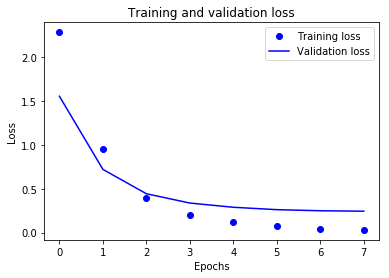

In [36]:
tfidf_model = models.Sequential()
tfidf_model.add(layers.Dense(128, input_shape=(train_tfidf.shape[1],)))
tfidf_model.add(layers.advanced_activations.LeakyReLU(alpha=0.01))
tfidf_model.add(layers.Dense(num_of_categories, activation='softmax'))
tfidf_model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = tfidf_model.fit(train_tfidf,
                      train_labels_oneHot,
                      epochs=8,
                      batch_size=128,
                      validation_data=(test_tfidf, test_labels_oneHot))
print("Final accuracy: ", tfidf_model.evaluate(test_tfidf, test_labels_oneHot, verbose=0)[1] )
print_history(history)


# serialize model to JSON
model_json = tfidf_model.to_json()
with open("/content/gdrive/My Drive/Colab Notebooks/model_tfidf.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
tfidf_model.save_weights("/content/gdrive/My Drive/Colab Notebooks/model_tfidf.h5")
print("Saved model to disk")




F1-Score (weighted):  0.984412946857049


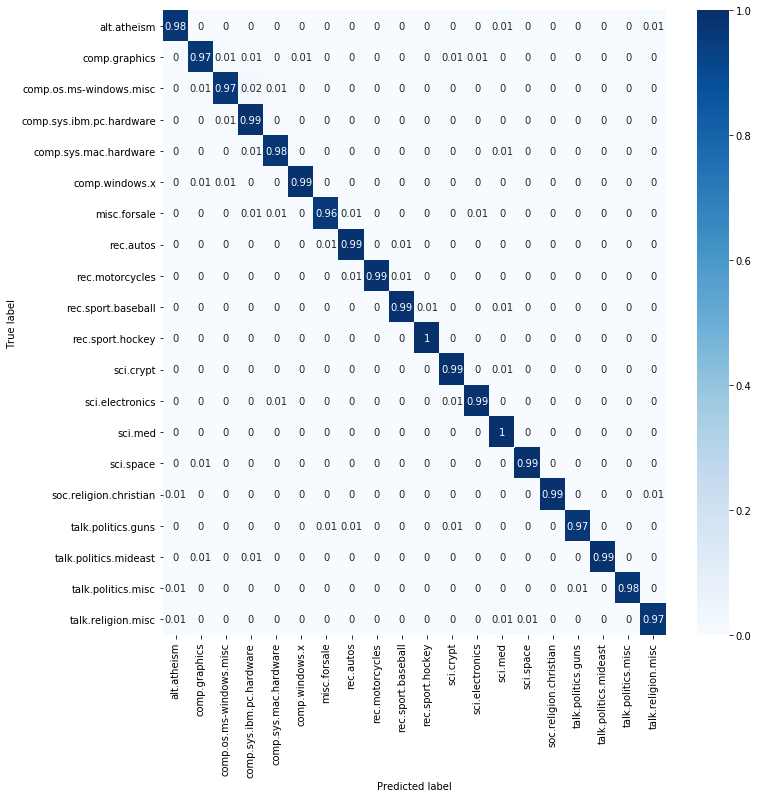

In [36]:
anaylze_model(tfidf_model, test_tfidf)

F1-Score (weighted):  0.9331759950031822


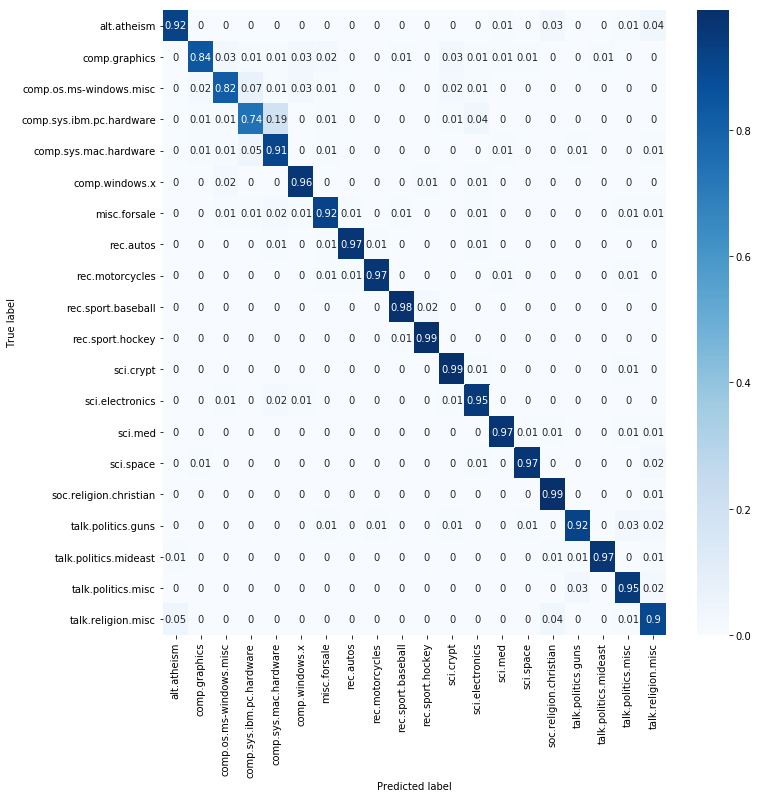

In [37]:
anaylze_model(rnn_model, test_rnn)